In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
import math


### Secuencialización horaria de fechas

Nos aseguramos de que las fechas son secuenciales y no se saltan ninguna hora.

In [14]:
def hours_sequential(df):
    print("Serializando horas")
    # Estandarizar el formato de las fechas
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)

    df['date'] = df['date'].apply(lambda x: f"{x} 00:00:00" if len(x) == 10 else x)
    
    # Convertir la columna 'date' a tipo datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Crear un rango completo de fechas con intervalos de 3 horas
    full_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='3H')
    
    # Crear un nuevo DataFrame con el rango completo de fechas
    df_full = pd.DataFrame(full_range, columns=['date'])
    
    # Hacer un merge para completar las fechas faltantes
    df_merged = pd.merge(df_full, df, on='date', how='left')

    return df_merged


### Ventana móvil

Ventana móvil con 2 fases.
1. Marca la "frontera" de los periodos válidos mirando hacia atrás. Marcará un 1 si el periodo de 365 días anterior es válido.
2. Refrescar el periodo de 365 días anterior a cada "flag" que tenga un 1, para marcar que el periodo ya es válido.

In [8]:

def set_rowling_window(df:pd.DataFrame, window_size= 365 * 8, nulls_tolerance= 15 * 8 ) -> pd.DataFrame:
    """
    window_size: tamaño de la ventana para el cálculo de la media móvil
    nulls_tolerance: número de nulos tolerados en la ventana
    """


    #Nos saltamos la columna de fecha e identificacion de la base
    for col in df.columns:
        if df[col].dtype != np.float64 and df[col].dtype != np.int64 or col == f'{col}_station':        
            continue
        print(f'{col} is a number')
        df[f'{col}_{station}'] = df[col].rolling(window=window_size, min_periods=1).apply(
            lambda x: 0 if x.isnull().sum() > nulls_tolerance or len(x) < window_size else 1
        )
        df[f'{col}_{station}'] = df[f'{col}_{station}'].replace({np.nan: 0})
        df[f'{col}_{station}'] = df[f'{col}_{station}'].astype(np.int8)

    return df

### Recalificación de flags

In [9]:

def recalificacion_flags(df: pd.DataFrame, window_size=365 * 8) -> pd.DataFrame:
    for col in df.columns:
        referenced_col = col.split('_')[0]
        
        if col.endswith(station):
            try:        
                print(f'{col} referenciando {referenced_col} va a ser reasignada ')
                for i in range(len(df[col])):
                    if df.iloc[i, df.columns.get_loc(col)] == 1:  # Acceder al valor de la columna con iloc
                        start_idx = max(0, i - window_size + 1)  
                        
                        # Buscar el primer índice no nulo en referenced_col dentro de la ventana
                        for j in range(start_idx, i + 1):
                            if not pd.isna(df.iloc[j, df.columns.get_loc(referenced_col)]):
                                df.iloc[j:i+1, df.columns.get_loc(col)] = 1  # Recalificar desde el primer índice no nulo hasta el índice actual
                                break  # Terminar la búsqueda una vez encontrado el primer valor no nulo
            except KeyError as e:
                print(f"Error: no se encontró la columna '{referenced_col}' para {col}. Eliminando {col}.")
                df = df.drop(columns=[col])  # Eliminar la columna problemática

            else:
                print(f'{col} NO va a ser reasignada ---> ')
    return df

### Visualización de los datos

In [10]:
def plot_all_data(df): 
    df['date'] = pd.to_datetime(df['date'])
    print ('Obteniendo gráficas generales')
    num_cols = 2
    num_rows = 3

    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(18, 10))  # Ajusta el tamaño de la figura según el número de filas


    # Aplanar el array de ejes para poder iterar sobre él
    axes = axes.flatten()

    # Iterar sobre las columnas (excluyendo 'fhora') y generar gráficos
    for ax, col in zip(axes, df.columns.drop('date')):
        station_col = f'{col}_{station}'  # Columna con el nombre de la estación

        if station_col in df.columns:  # Verificar si la columna _station existe
            print(f'Graficar {col} en el primer eje Y (ax)')
            
            # Primer eje Y para la columna principal
            color = 'tab:blue'
            ax.set_xlabel('date')
            ax.set_ylabel(col, color=color)
            sns.lineplot(x=df['date'], y=df[col], ax=ax, color=color, label=col)
            ax.tick_params(axis='y', labelcolor=color)
            ax.set_title(f'{col} a lo largo del tiempo')

            # Segundo eje Y para la columna _station
            ax2 = ax.twinx()  
            color = 'tab:orange'
            ax2.set_ylabel(station_col, color=color)
            sns.lineplot(x=df['date'], y=df[station_col], ax=ax2, color=color, label=station_col)
            ax2.tick_params(axis='y', labelcolor=color)

            # Rotar las etiquetas del eje X para mejor legibilidad
            ax.tick_params(axis='x', rotation=45)
            
    # Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 6
    for i in range(num_cols * num_rows, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(f'resource/new/flagged_{station}.png')
    plt.show()

### Generación del heatmap

In [12]:
def plot_heatmap(df):
    df['date'] = pd.to_datetime(df['date'])
    df_flags = df[[col for col in df.columns if station in col]]
    df_flags['date'] = df['date']

    df_flags.set_index('date', inplace=True)
    df_flags.index = pd.to_datetime(df_flags.index)
    df_flags.index = df_flags.index.to_period('M') 

    num_cols = len(df_flags.columns)-1

    num_rows = math.ceil(num_cols / 3)  
    print ('Obteniendo mapa de calor')
    print(num_cols, num_rows)

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 8 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

    # Aplanar el array de ejes para poder iterar sobre él
    axes = axes.flatten()

    # Iterar sobre las columnas y generar gráficos
    for ax, col in zip(axes, df_flags.columns):
        if col != 'date':
            print(f'{col} procede al mapa de calor')
            sns.heatmap(df_flags[[col]], cbar=False, cmap='viridis', ax=ax)
            ax.set_title(col)
        

    # Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 3
    if num_cols % 3:
        for ax in axes[num_cols:]:
            ax.remove()

    plt.tight_layout()
    plt.savefig(f'resource/heatmap_{station}_window.png')
    plt.show()

    df.head()

### Carga de dataframes y ejecución

In [15]:
path = './data/data_jan'

WINDOW_SIZE = 365 * 8
NULLS_TOLERANCE = 15 * 8

for file in os.listdir(path):
    station = file.split('.')[0]
    input_file = f'{station}.csv'
    
    try:
        df = pd.read_csv(os.path.join(path, input_file))
        df.head()
        print(f'Nombre del input csv: {input_file}')
    except Exception as e:
        print(f'ERROR EN LA LECTURA DE LA ESTACIÓN {station} ---> {e}')
        continue
    
    df = hours_sequential(df) 
    df = df[df['date'].dt.hour % 3 == 0]
    df = set_rowling_window(df, window_size=WINDOW_SIZE, nulls_tolerance=NULLS_TOLERANCE)
    df = recalificacion_flags(df, window_size=WINDOW_SIZE)
    df.to_csv(f'./data/flagged_jan/{station}_flagged.csv', index=False)
    


Nombre del input csv: king.csv
Serializando horas
king.temp is a number


/tmp/ipykernel_90349/2238800431.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='3H')


king.pres is a number
king.hr is a number
king.vel is a number
king.dir is a number
king.prec_king is a number
king.dew_king is a number
date NO va a ser reasignada ---> 
king.temp NO va a ser reasignada ---> 
king.pres NO va a ser reasignada ---> 
king.hr NO va a ser reasignada ---> 
king.vel NO va a ser reasignada ---> 
king.dir NO va a ser reasignada ---> 
king.temp_king referenciando king.temp va a ser reasignada 
king.dir_king referenciando king.dir va a ser reasignada 
king.vel_king referenciando king.vel va a ser reasignada 
king.hr_king referenciando king.hr va a ser reasignada 
king.prec_king referenciando king.prec va a ser reasignada 


KeyError: 'king.prec'

### Obtener las gráficas de todos los dataset


Found directory: carlini_flagged.csv
Nombre del input csv: ./flagged_data/carlini_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


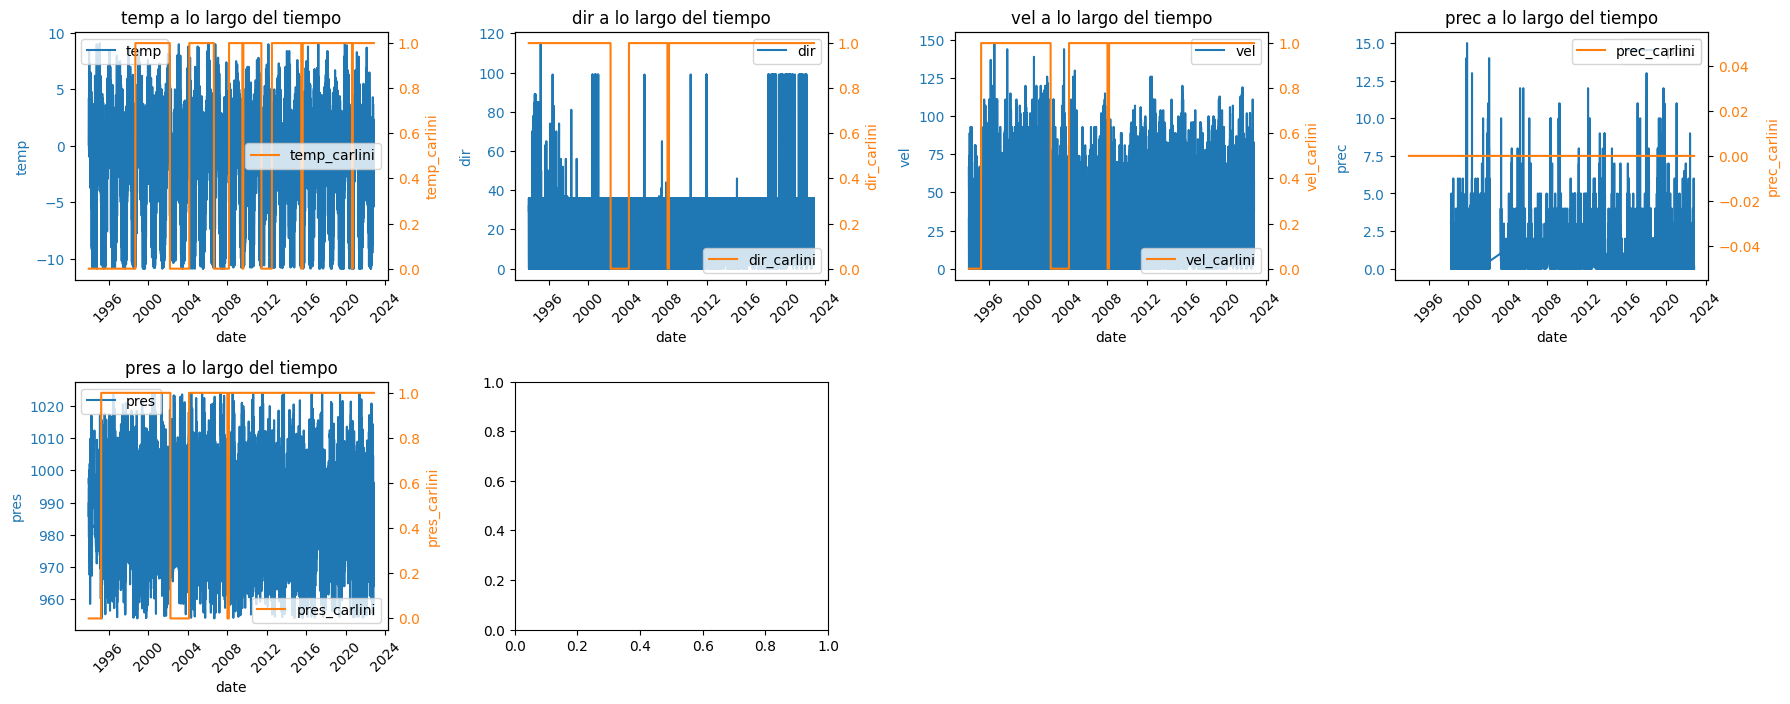

Found directory: esperanza_flagged.csv
Nombre del input csv: ./flagged_data/esperanza_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


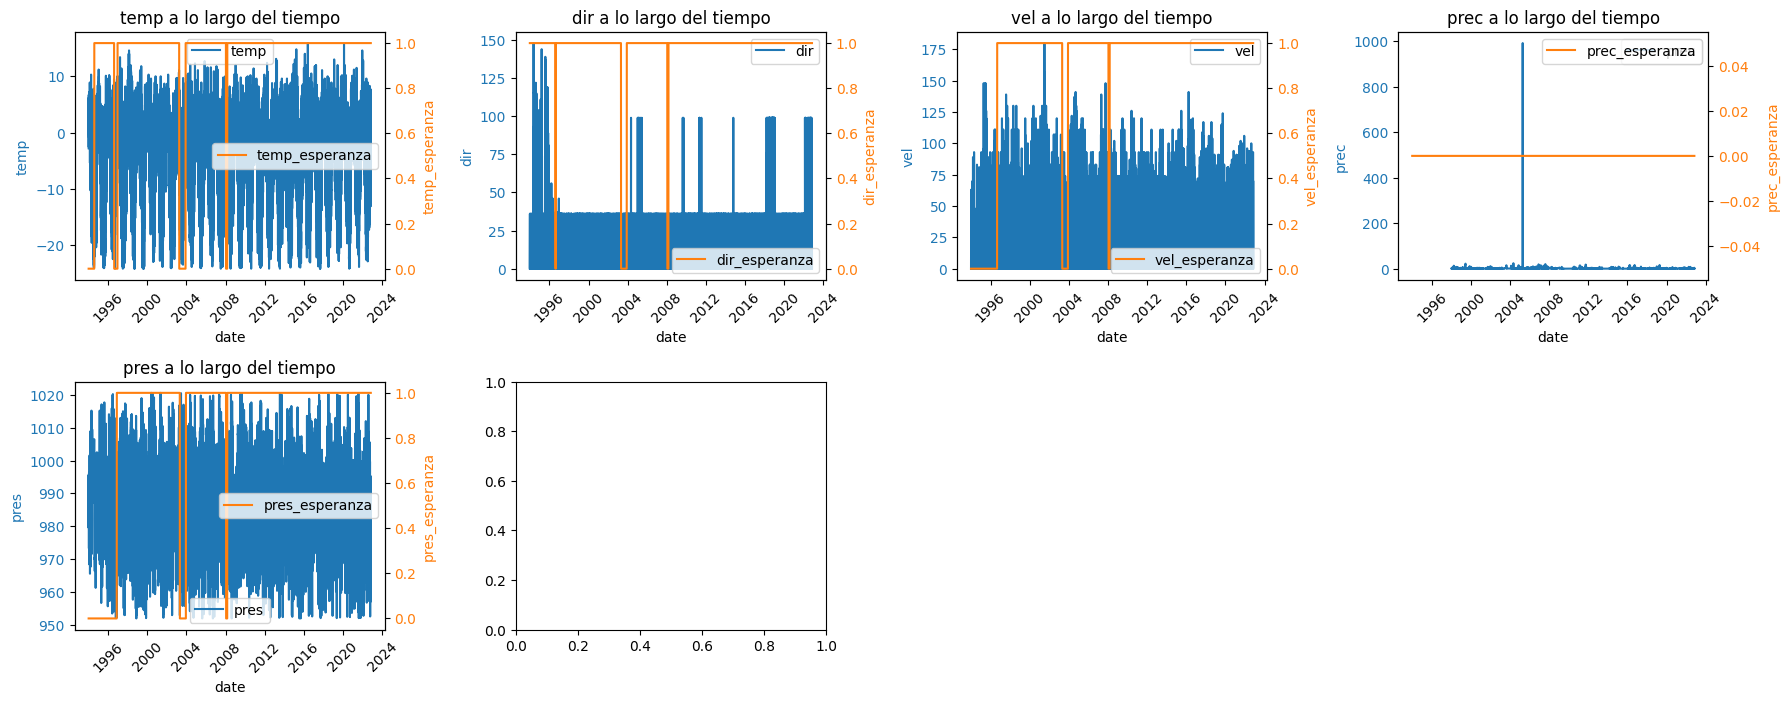

Found directory: figures
ERROR EN LA LECTURA DE LA ESTACIÓN figures ---> [Errno 13] Permission denied: './flagged_data/figures'
Found directory: jci_flagged.csv
Nombre del input csv: ./flagged_data/jci_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar skt en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar hr en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


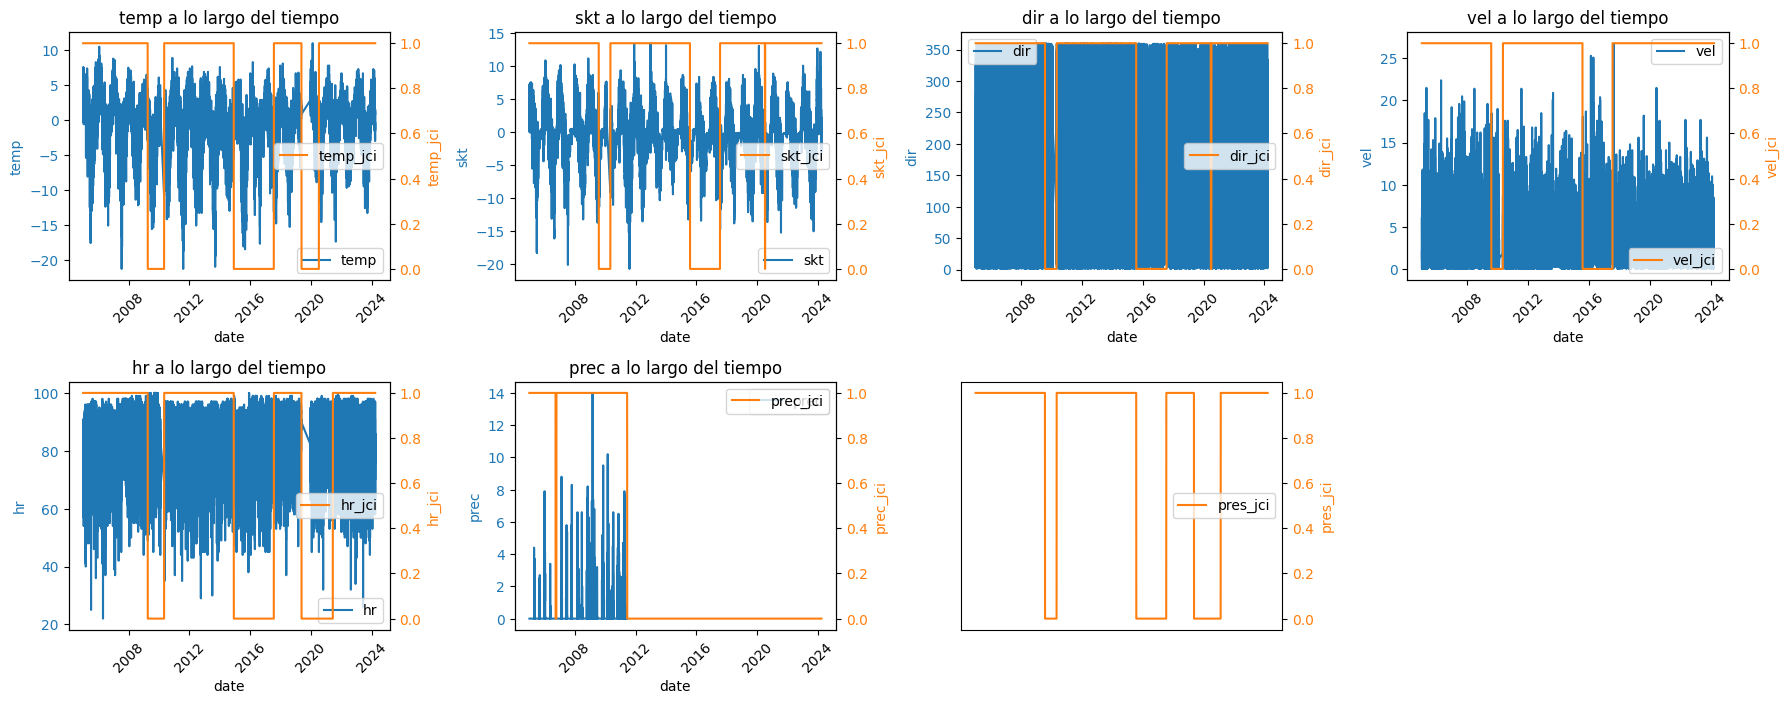

Found directory: NO
ERROR EN LA LECTURA DE LA ESTACIÓN NO ---> [Errno 13] Permission denied: './flagged_data/NO'
Found directory: ohiggins_flagged.csv
Nombre del input csv: ./flagged_data/ohiggins_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar hr en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


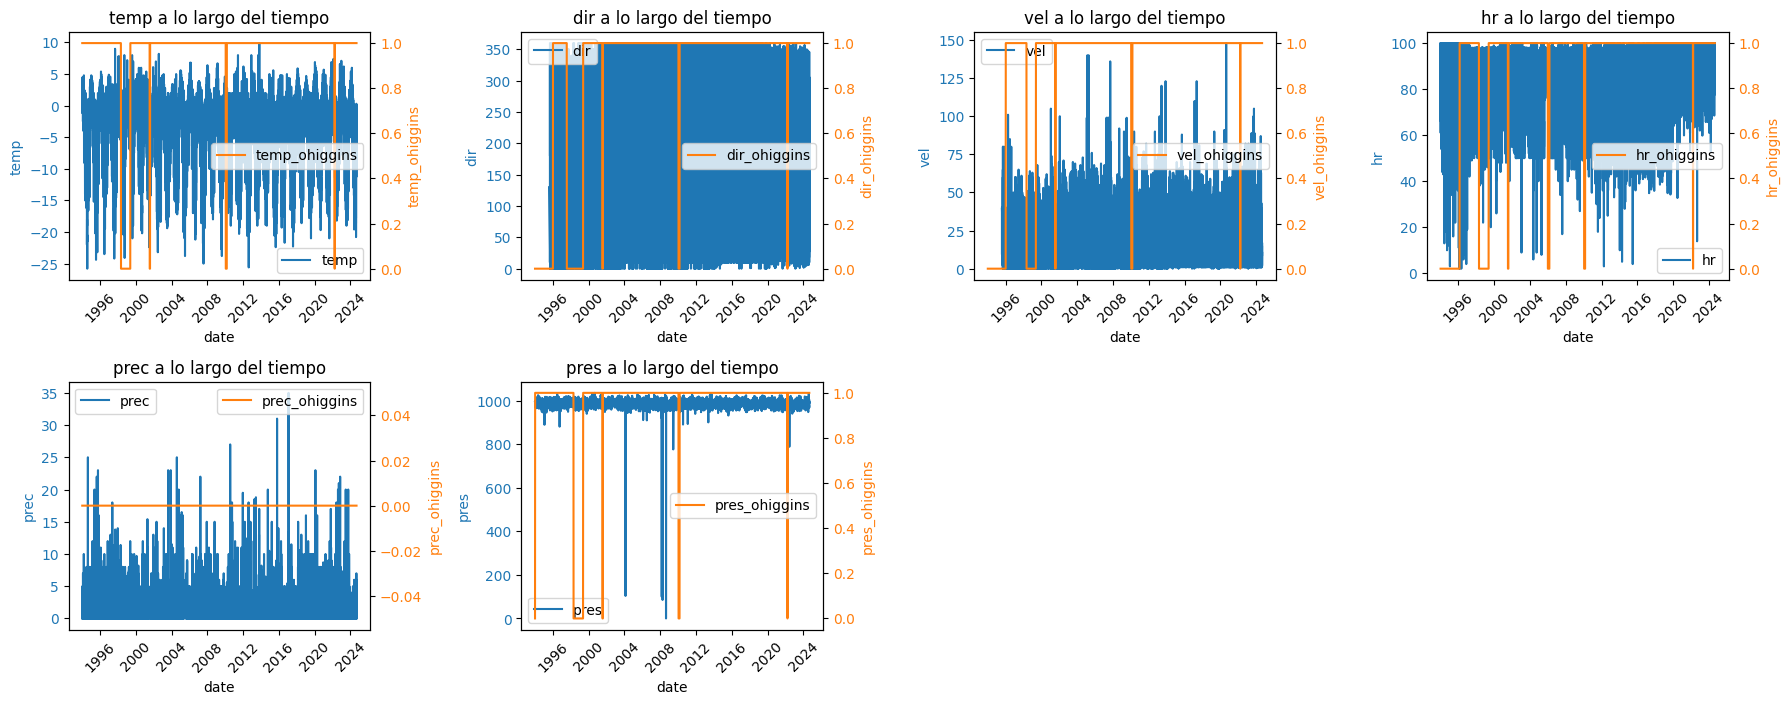

Found directory: palmer_flagged.csv
Nombre del input csv: ./flagged_data/palmer_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar hr en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


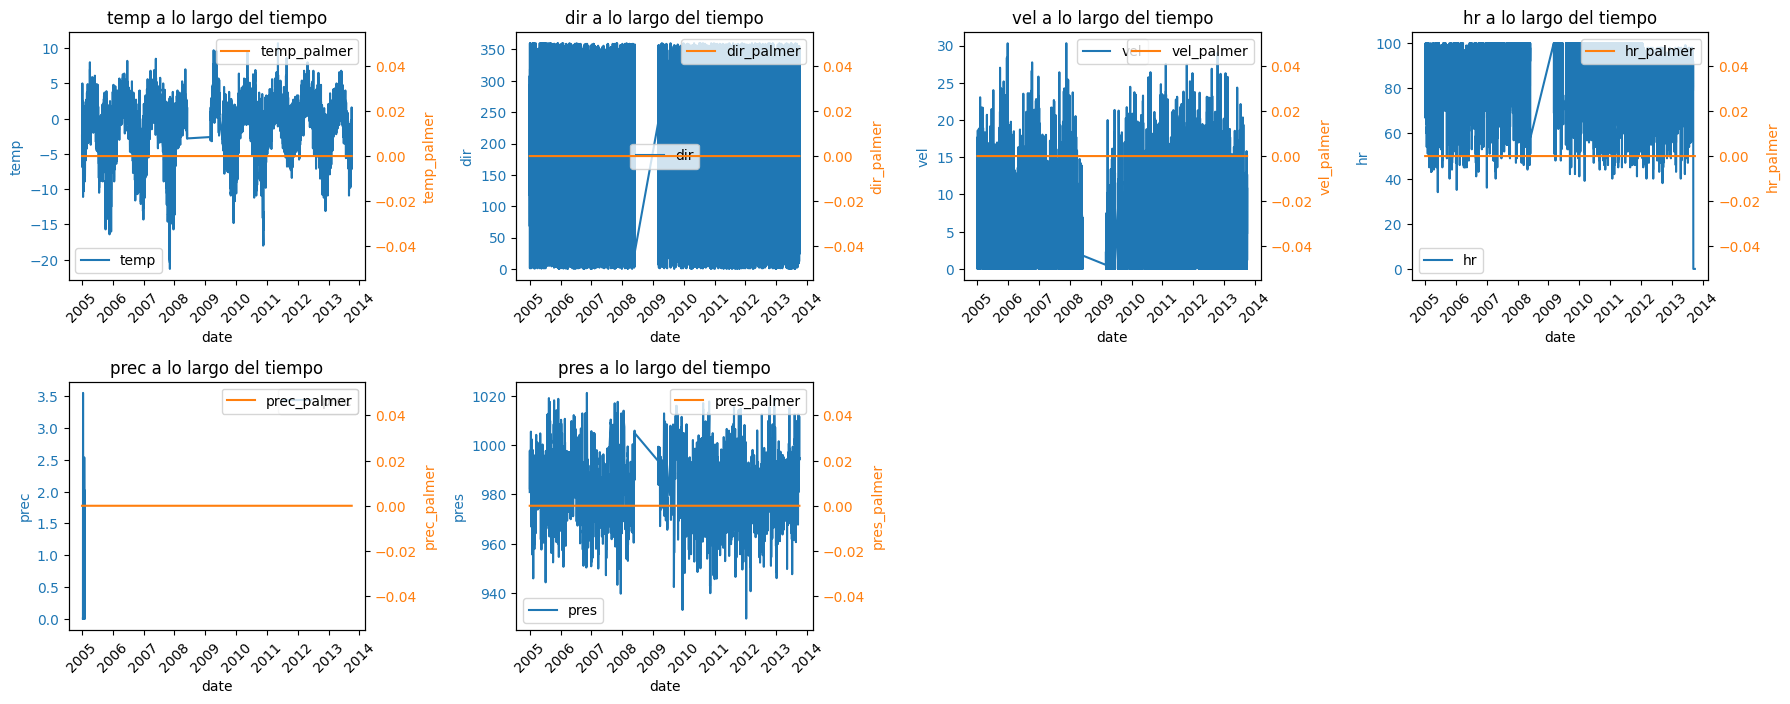

Found directory: rothera_flagged.csv
Nombre del input csv: ./flagged_data/rothera_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar hr en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)


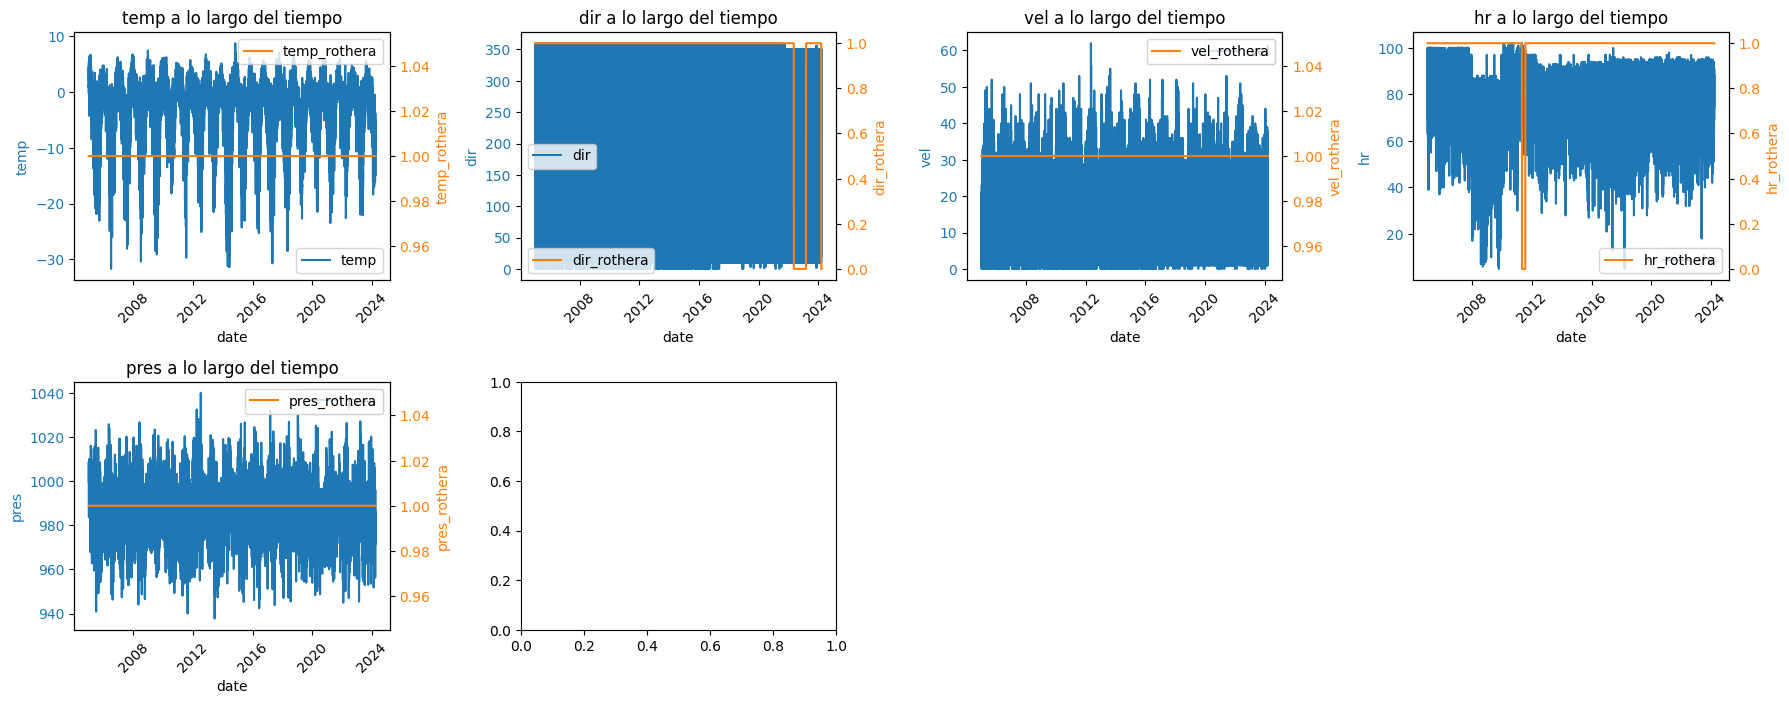

Found directory: vernadsky_flagged.csv
Nombre del input csv: ./flagged_data/vernadsky_flagged.csv
Obteniendo gráficas generales
Graficar temp en el primer eje Y (ax)
Graficar dir en el primer eje Y (ax)
Graficar vel en el primer eje Y (ax)
Graficar pres en el primer eje Y (ax)
Graficar hr en el primer eje Y (ax)
Graficar prec en el primer eje Y (ax)


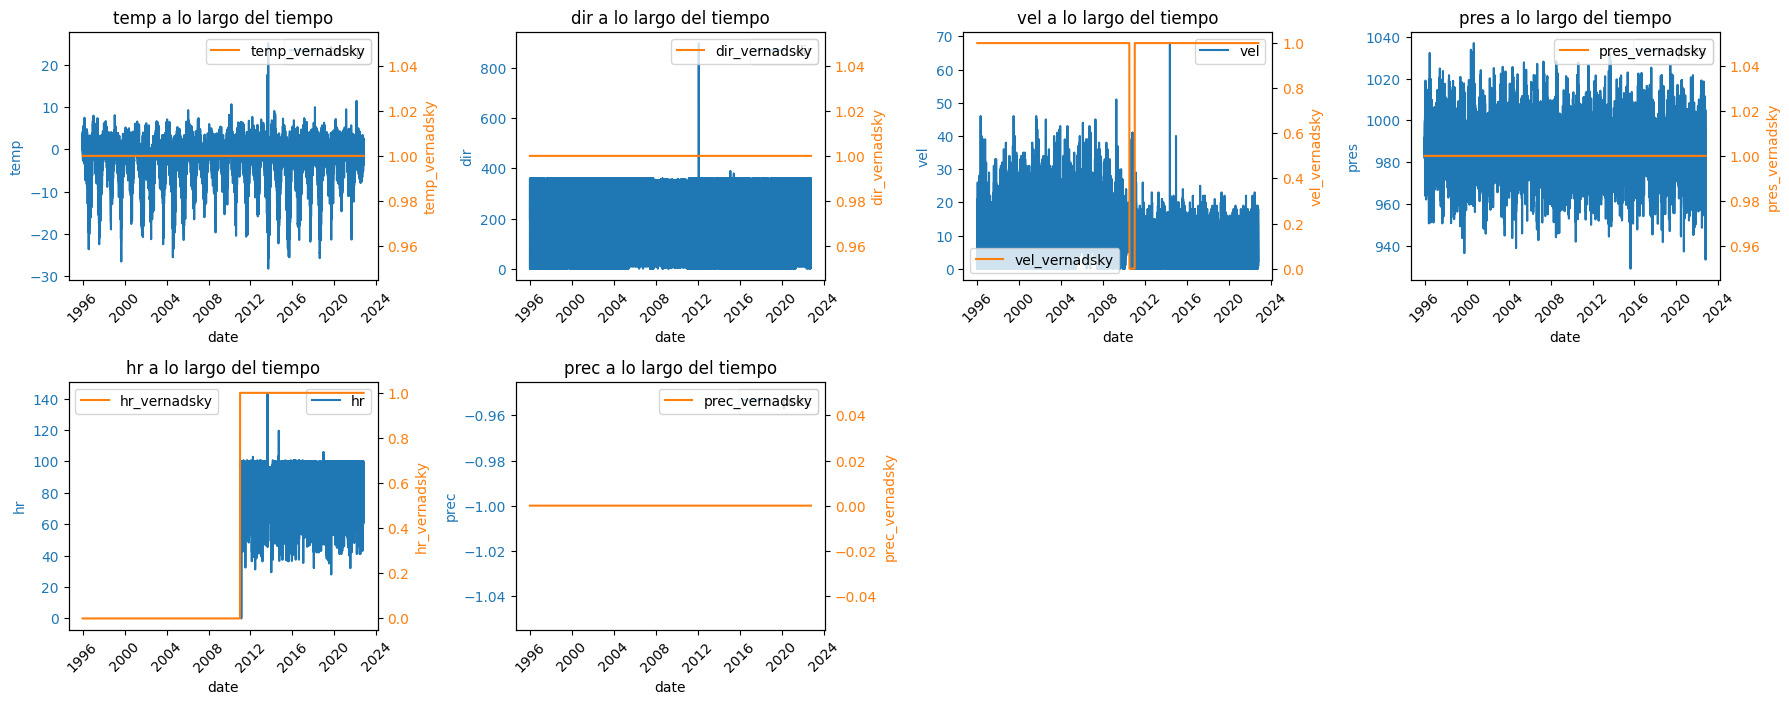

In [15]:

path = './flagged_data/'
filenames = os.listdir(path)

for filename in filenames:
    print(f'Found directory: {filename}')
    file_path = os.path.join(path, filename)
    station = filename.split('_')[0]
    try:
        df = pd.read_csv(file_path)
        df.head()
        print(f'Nombre del input csv: {file_path}')
    except Exception as e:
        print(f'ERROR EN LA LECTURA DE LA ESTACIÓN {station} ---> {e}')
        continue

    try:
        plot_all_data(df)
        # plot_heatmap(df)
    except Exception as e:
        print(f'ERROR AL OBTENER LA GRÁFICA DE {station} ---> {e}')
        continue

    